In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' # 设置图片清晰度
plt.rcParams['font.sans-serif'] = ['Simsun']   # 指定默认字体 Simsun为宋体
plt.rcParams['axes.unicode_minus'] = False     # 解决保存图像时负号‘-’显示为方块的问题

import time, re

In [2]:
# pht表：主播id表
pht = pd.read_csv('data\用户id.csv')

LDA主题模型  
步骤：

①去除停用词（使用哈工大停用词表）；

②采用jieba分词，其中jieba分词库中加入LOL常用词汇，如英雄昵称、英雄位置；

③使用gensim库corpora模块下的Dictionary类，创建字典；

②基于构建的字典，将每个直播标题转为词袋模型；

③构建并训练LDA模型，根据困惑度和一致性指标选出合适的主题个数

#### 直播间标题

In [3]:
ht = pd.read_csv(r'data\4月4日数据.csv')
ht.fillna(method='bfill', inplace=True)        # 填充抓取时间的缺失值
ht['get_time'] = ht.get_time.map(time.localtime).map(lambda x: time.strftime("%Y--%m--%d %H:%M:%S", x)).astype('datetime64')  # 时间戳转日期格式
ht = ht.rename(columns={'uid':'用户id'})        # 重命名列名

In [4]:
a = ht.drop_duplicates('用户id')[['用户id','roomName']].rename(columns={'roomName':'直播标题'})
pht = pd.merge(pht, a, on='用户id', how='left')

对直播标题做LDA聚类，得到聚类后的主题

In [6]:
with open('data\热门英雄字典.txt', 'r') as f:
    英雄字典 = f.read()
英雄 = eval(英雄字典).keys()     # 英雄名称列表

In [7]:
import jieba, re
from gensim import corpora, models  # models.LdaModel LDA模型
from collections import defaultdict

# 添加jieba分词，不希望被分开的词
jieba_add_word = ['粉丝群', 'B站', 'BC勿扰', '周一', '周二', '周三', '周四', '周五', '周六', '周日','一点','0点', '1点', '2点', '3点', '4点', '5点', '6点', '7点', '8点', '9点', '10点', '11点', '12点', '13点', '14点', '15点', '16点', '17点', '18点', '19点', '20点', '21点', '22点', '23点', '24点',
             '大号','乱杀','秒人流','五杀','上单','辅助','打野','ADC','中单','下路','国服第一','第一','AD','人美','声甜','一起玩','可爱','万场','千场','灵活排位','双排','单双排','峡谷之巅','豹女','颜值','新人','新主播','黑色玫瑰','艾欧尼亚','一区','网一','有车位','欢迎来到','的直播间','内战','上分','帮打',
             '一颗小虎牙','哥哥','上号','猫咪','一打五']  
for i in jieba_add_word:
    jieba.add_word(i)

# 添加英雄词
for i in 英雄:
    jieba.add_word(i)

# 要删除的jieba分词，比如"玩吧"会使"一起玩吧"变成"一起"和"玩吧"，而"一起玩"更具有代表性和普遍性。
jieba_del_word = ['之上','玩吧']
for j in jieba_del_word:
    jieba.del_word(j)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\CAIQIU~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.715 seconds.
Prefix dict has been built succesfully.


##### **第一步，生成嵌套列表。**  
嵌套列表，即一个文档/直播间标题是一个列表（分词、去停用词后），如果有多个文档/直播间标题，则需要将多个列表组合起来形成一个嵌套列表。

In [11]:
# 建立去除停用词的正则表达式
# 自己加入的停用词
r = '[a-zA-Z0-9!"#$%&\'·丨『』☆()（）*+,-./:：;<=>?@，。?★、…【】《》？“”‘！[\\]^_`{|}~\s]+|、|丶|我|是|你|的|就|一个|呀|鸭|丫|吖|想|了|吧|吗|嘛|不|群|便|啊|哈|哦|啦|灬|局|' 

# 哈工大停用词
with open('data\哈工大停用词表.txt', 'r', encoding='utf-8') as f:
    Stop = f.read()
r_stop = re.sub('\n', '|', Stop)[955:]

# 用两种停用词来建立正则表达式
r = r + r_stop

In [62]:
# 嵌套列表
直播标题词袋 = pht.直播标题.apply(lambda x: re.sub(r,'', x)).map(jieba.cut).map(list).to_list()
pht['直播标题词袋'] = 直播标题词袋

直播标题词袋[:5]          # 查看嵌套列表

[['打', '大号', '维护'],
 ['韩服', '乱杀', '职业', '选手'],
 ['三项', '爷青回', '赵信', '发财', '老枪', '笑'],
 ['中路', '杀神', '血洗', '峡谷', '秒人流', '卡牌', '蒸发'],
 ['第一', '男枪', '张嘉', '文教', '闭眼', '一打五']]

##### **第二步：构建字典——dictionary**  
构建字典的目的主要是生成一个词袋，里面的词来自于文档，并且没有重复的词。
[gensim corpora的简单使用](https://blog.csdn.net/Yolen_Chan/article/details/84934928)

In [76]:
dictionary = corpora.Dictionary(直播标题词袋)     # 生成词频字典 {词：频率}

dictionary.dfs         # 返回字典：{单词id：在多少文档中出现}
# 输出：{1: 64, 3: 5, 0: 216, 2: 162, 5: 62, 6: 18, 4: 44, 8: 31, 7: 26,...}
dictionary.token2id;   # 返回字典：{单词：id}  id也即独一无二的编号
# 输出：{'号': 0, '大': 1, '局': 2, '维护': 3, '乱': 4, '杀': 5, '职业': 6,...}
print(dictionary)

Dictionary(8570 unique tokens: ['大号', '打', '维护', '乱杀', '职业']...)


可见，由嵌套列表生成的字典共有8570个唯一的词。

In [77]:
# 手动去除一些没有实际意义词(单个字的词)，弥补停用词不全面的缺点
bad_ids = []
for key,value in dictionary.token2id.items():
    if len(key)==1:    # 如果词为单个字，那么将其id存放到bad_ids列表中
        bad_ids.append(value)

dictionary.filter_tokens(bad_ids=bad_ids)   # 去除bad_ids列表中的词id
dictionary.compactify()    # 去除了单个字的词之后，重新对单词id进行排序。

##### **第三步：构建语料库——corpus（词袋模型 BOW--bag of words）**

> 什么是语料库：  
词袋形象地解释便是：将文本中的词放入一个袋子里，在袋子中，词拥有两个属性编号和数目（id，num）。一个词袋对应一篇文档。由元组（单词id,出现次数num)构成的 [(0, 1), (1, 2), (2, 1)] 则称作稀疏向量。一般语料库都是用这种方式来表示。

In [79]:
corpus = [dictionary.doc2bow(text) for text in 直播标题词袋]  # 生成语料库

corpus[:3]              # 查看语料库

[[(0, 1), (1, 1)],
 [(2, 1), (3, 1), (4, 1), (5, 1)],
 [(6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]]

以第一个子列表为例，(0,1)表示的是，id为0的单词在第一篇文档/直播间标题出现次数是1；(1,1)表示的是id为1的单词在第一篇文档/直播间标题出现次数是1以此类推。

##### **第四步：训练LDA模型**  

In [26]:
# LDA模型的训练
# corpus：语料库
# iterations：最大迭代次数
num_topics = 3        # 设置主题个数
lda = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
        iterations=500, random_state=123)

##### **第五步：选择合适的主题个数** 
[lda主题模型困惑度_主题模型（三）：LDA主题个数选择](https://blog.csdn.net/weixin_39676021/article/details/112187210)

计算每个模型的困惑度，根据困惑度的实验结果，在合理的范围内进行一致性实验。最后得出效果最好主题个数。  
> 主题数越多，困惑度越低，但会出现过拟合的情况，故需要一致性指标辅助判断

In [28]:
# 保存2-15个主题数的lda模型，迭代次数为500
for num_topic in range(2, 16):
    lda = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic,
        iterations=500)
    lda.save('LDA模型数据\lda_model_直播标题\lda_topic%s.model'%num_topic)

###### 5.1 困惑度确定主题数范围

In [24]:
def perplexity_visible_model(model_path, topic_range=range(2,16)):
    '''
    获取不同主题下的困惑度，并绘制折线图
    parameters:
        topic_range: list, eg: range(2,16) 训练2-15各主题的lda
        model_path: 模型储存在哪个路径文件夹下
    return：
        perplexity: list, 每个主题对应的困惑度
    '''
    perplexity_list = []      # 用于存放困惑度
    for num_topic in topic_range:
        # 训练lda模型
        lda = models.LdaModel.load(f'{model_path}\lda_topic{num_topic}.model')
        # 计算困惑度
        perplexity = lda.log_perplexity(corpus)
        perplexity_list.append(perplexity)

    plt.plot(topic_range, perplexity_list)
    plt.xlabel('num topics')
    plt.ylabel('perplexity score')
    plt.legend(('perplexity_values'), loc='best')
    
    return perplexity_list

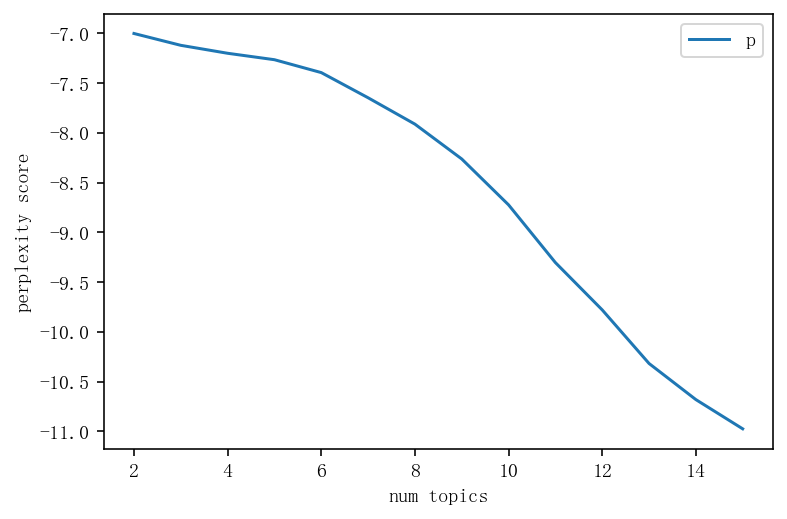

In [32]:
perlexity_list = perplexity_visible_model(topic_range=range(2, 16), model_path='LDA模型数据\lda_model_直播标题')

由上图发现，当主题个数超过5
时，模型的困惑度就会急剧下降。故初步将主题数定在1-5之间。

###### 5.2 绘制主题数和一致性的变化

In [25]:
def coherence_visible_model(model_path, topic_range=range(2,16)):
    '''
    计算不同主题个数下的一致性，并绘制折线图
    parameters：
        topic_range：list, eg: range(2,15) 主题数范围为2-15
        model_path：存放lda模型的文件夹的路径
    return:
        coherence_list：每个主题对应的一致性
    '''
    coherence_list = []      # 存放困惑度
    
    for num_topic in topic_range:
        lda = models.LdaModel.load(f'{model_path}\lda_topic{num_topic}.model')
        # 计算一致性
        cm = models.CoherenceModel(model=lda, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        coherence = cm.get_coherence()
        coherence_list.append(coherence)
        
    plt.plot(topic_range, coherence_list)
    plt.xlabel('num topics')
    plt.ylabel('coherence score')
    plt.legend(('coherence_values'), loc='best')
    
    return coherence_list

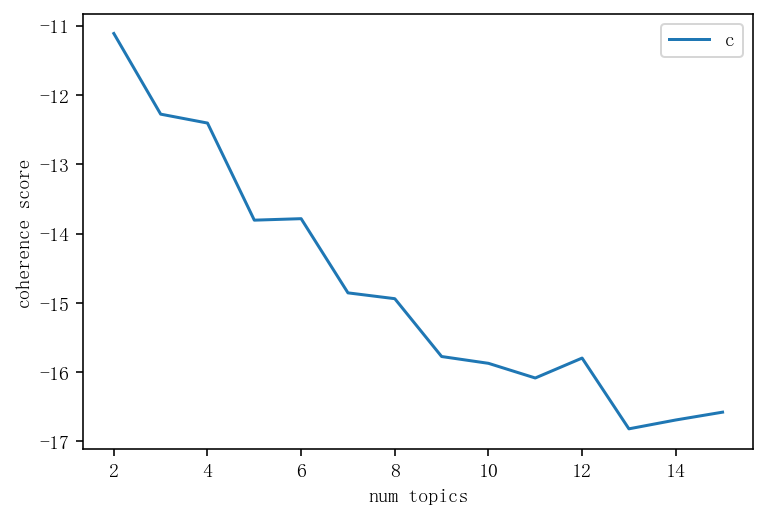

In [34]:
coherence_list = coherence_visible_model(topic_range=range(2, 16), model_path='LDA模型数据\lda_model_直播标题')

可见当主题数为2时，模型评分最高。  
当主题数为4、5时，主题4和主题5的样本数过少，所以不宜分为4、5类。

###### 5.3 网页版pyLDA 可视化模型

[pyLDA save html打不开怎么办](https://blog.csdn.net/m0_37953759/article/details/112861688)

In [71]:
import pyLDAvis.gensim

In [80]:
num_topic = 2
lda = models.ldamodel.LdaModel.load('LDA模型数据\lda_model_直播标题\lda_topic%s.model'%num_topic)
vis_data = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.show(vis_data, open_browser=False)

<>:2: DeprecationWarning: invalid escape sequence \l
<>:2: DeprecationWarning: invalid escape sequence \l
<>:2: DeprecationWarning: invalid escape sequence \l
<ipython-input-80-e2bd24ad496a>:2: DeprecationWarning: invalid escape sequence \l
  lda = models.ldamodel.LdaModel.load('LDA模型数据\lda_model_直播标题\lda_topic%s.model'%num_topic)
D:\software\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))



Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]

stopping Server...


##### **第六步：查看各主题的主题词**

In [8]:
num_topic = 2
lda = models.LdaModel.load('LDA模型数据\lda_model_直播标题\lda_topic%s.model'%num_topic)  # 读取提前存储的模型

# lda.print_topics(num_words)：获取每个主题前`num_words`个重要的单词
topic_list = lda.print_topics(num_words=20)
'''
topic_list：
[(0, '0.030*"玩" + 0.029*"黑色" + 0.024*"虎牙" + 0.020*"玫瑰" + 0.015*"颗" + 0.009*"尼亚" + 0.009*"艾欧" + 0.009*"上车" + 0.009*"灵活" + 0.009*"订阅"'),
 (1, '0.016*"峡谷" + 0.008*"区" + 0.008*"人" + 0.008*"钻石" + 0.006*"专场" + 0.006*"福星" + 0.006*"娱乐" + 0.005*"网" + 0.005*"局" + 0.005*"上"'),
 (2, '0.009*"号" + 0.009*"快乐" + 0.008*"免费" + 0.008*"好" + 0.008*"玩玩" + 0.008*"上分" + 0.007*"分" + 0.007*"教学" + 0.007*"上" + 0.007*"吃"')]
''';
# 整理成dataframe结构，方便查看
pd.DataFrame([re.findall('"(.*?)"', t[1]) for t in topic_list])
# 段位较低（白银），以娱乐为主（快乐，克隆模式），新人直播标题（欢迎来到××的直播间，我是一颗小虎牙）—— 低段新手娱乐
# 段位较高（王者、艾欧尼亚、教学、），一起玩（黑色玫瑰、上车、车位、大乱斗）—— 高段开黑

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,直播间,欢迎来到,一颗小虎牙,上分,虎牙,克隆,快乐,英雄,今天,白银,联盟,日常,云顶,德玛,教学,西亚,一只,开心,艾克,双人
1,一起玩,黑色玫瑰,上车,王者,订阅,黑色,艾欧尼亚,峡谷,车位,教学,大乱斗,娱乐,直播,一区,灵活,钻石,黄金,主播,排位,上单


##### **第七步：打印出dataframe中各个直播间标题所属主题的概率。**  
（需要先将文档转为词袋形式[(id,num)...]，再用lda模型预测）

In [37]:
# 提取出每个直播间标题在每个主题上的概率
lda_result = pht.直播标题词袋.apply(lambda x: lda.get_document_topics(dictionary.doc2bow(x)))
lda_result[:3]     # 主题0——概率0.8， 主题1——概率0.08，主题2——概率0.08

0     [(0, 0.19191918), (1, 0.80808085)]
1    [(0, 0.100790784), (1, 0.89920926)]
2      [(0, 0.14028782), (1, 0.8597121)]
Name: 直播标题词袋, dtype: object

In [38]:
# 将Series转化为[{}, {}, ...{}]格式，以便转为dataframe格式——Topics，然后与pht表合并
lda_result_data = lda_result.map(dict).to_list()

Topics = pd.DataFrame(lda_result_data)
Topics.columns = ['直播Topic%s'%i for i in range(1, num_topic+1)]
pht = pd.concat((pht, Topics), axis=1, join='inner')
pht.head(2)

,用户id,直播标题,直播标题词袋,直播Topic1,直播Topic2
0,1820796294,打把大号维护局！,"[打, 大号, 维护]",0.191919,0.808081
1,2183525275,韩服乱杀职业选手,"[韩服, 乱杀, 职业, 选手]",0.100791,0.899209


In [39]:
# pht['Topic']   直播间标题的主题
pht['直播标题主题'] = pht[['直播Topic%s'%i for i in range(1, num_topic+1)]].apply(lambda x: x.argmax()[-1], axis=1)
pht['直播标题主题概率'] = pht[['直播Topic%s'%i for i in range(1, num_topic+1)]].max(axis=1)
pht.直播标题主题.value_counts()

D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  


2    5765
1    5196
Name: 直播标题主题, dtype: int64

In [40]:
a = pht.sort_values('直播标题主题概率', ascending=False)
for i in range(1, num_topic+1):
    print('——————Topic%s——————'%i)
    display(a[a.直播标题主题==str(i)].直播标题.head(20))

——————Topic1——————


10754    欢迎来到【丐帮】狗彻家的瓜娃籽籽籽籽籽籽籽籽籽籽的直播间
10725                欢迎来到晚风吹起鬓间白发的直播间
6260              欢迎来到时代-天际-雾散真可爱的直播间
9924             逃离塔科夫离线版，送修改数据，可帮安装！
4703                欢迎来到一位失去斗志的网友的直播间
10177              欢迎来到放肆的青春诠释了悲伤的直播间
3082                 欢迎来到森少讲解小米晓峰的直播间
10638                  阳光大男孩，快乐小丑准备作战
10347               欢迎来到齐鲁工业大学小王子的直播间
10445                 欢迎来到一只野生小男枪的直播间
10629              欢迎来到豆沙宝贝汐【酒倒满】的直播间
6800                  欢迎来到寻梦-疯狂小龙的直播间
7739             不加工会不加工会不加工会不加工会不加工会
10635                 欢迎来到仙仙仙仙气飘飘的直播间
10946                欢迎来到文家铁骑-潘小帅的直播间
10911                欢迎来到热恋中从未听讲过的直播间
10837                  欢迎来到什锦香肠炒饭的直播间
7492                欢迎来到英雄联盟--天然呆的直播间
9388                  欢迎来到揽秀-一只小熊的直播间
9232                   欢迎来到岳家虎牙少年的直播间
Name: 直播标题, dtype: object

——————Topic2——————


5888    黑玫瑰温柔粘人小姐姐通宵车排位匹配一起玩
1059    萌新解惑，欢迎提问。谢谢 订阅 谢谢陪伴
5655    雷瑟守备白金钻石局 你得螳螂人马打野导师
5046      水晶之痕 最菜铂金下棋乱斗主播求赐教
3817    雷瑟守备大师局奥拉夫三级必单吃不单请举报
756     黑色玫瑰白银黄金灵活 关注免费上车来固玩
2443    重庆小姐姐 黑色灵活组排有位置 一起玩~
5379     黑色灵活排新主播浙江小姐姐有车位一起玩
2327    <湖南>黑色玫瑰灵活组排通宵有位置一起玩
5738      成都小姐姐电六战争学院车位多多一起玩
3857      黑色灵活有位置一起玩，女野王带飞全场
1419      帮安排，艾欧尼亚王者国服最强寡妇男刀
594      电一艾欧尼亚匹配乱斗灵活代币之路一起玩
8127     第一天直播的河北小姐姐，网三上车一起玩
5597    黑色玫瑰|新主播声优小姐姐订阅2血瓶上车
1533    巨神峰黄金到白金的单子 专业辅助可以上车
6354     超甜小姐姐黑色玫瑰 黄金铂金上车一起玩
9240    网一钻石局河南妹妹可可爱爱没有脑袋一起玩
5378      黑色长沙小姐姐千场安妮在线挨揍一起玩
1255     四川少女音新主播，电一黑色有车位一起玩
Name: 直播标题, dtype: object

##### **第八步：储存为字典.txt**

In [47]:
# 储存{用户id：直播标题}字典
with open('data\用户id_直播标题字典.txt', 'w') as f:    
    title_id = str(pht.set_index('用户id')['直播标题主题'].to_dict())
    f.write(title_id)

##### 第九步：绘制词云图

In [63]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from PIL import Image                            # 读取图片
# text_cut = 'recommend go use money someth 3 button stop work month use...' # text_cut的格式：把词袋拼接成str

background = Image.open("data/虎牙图标.png")
graph = np.array(background)
pic_color=ImageColorGenerator(graph)   #根据图片生成颜色函数

text_cut = ' '.join(pht.直播标题词袋.apply(lambda x: ' '.join(x)).to_list())

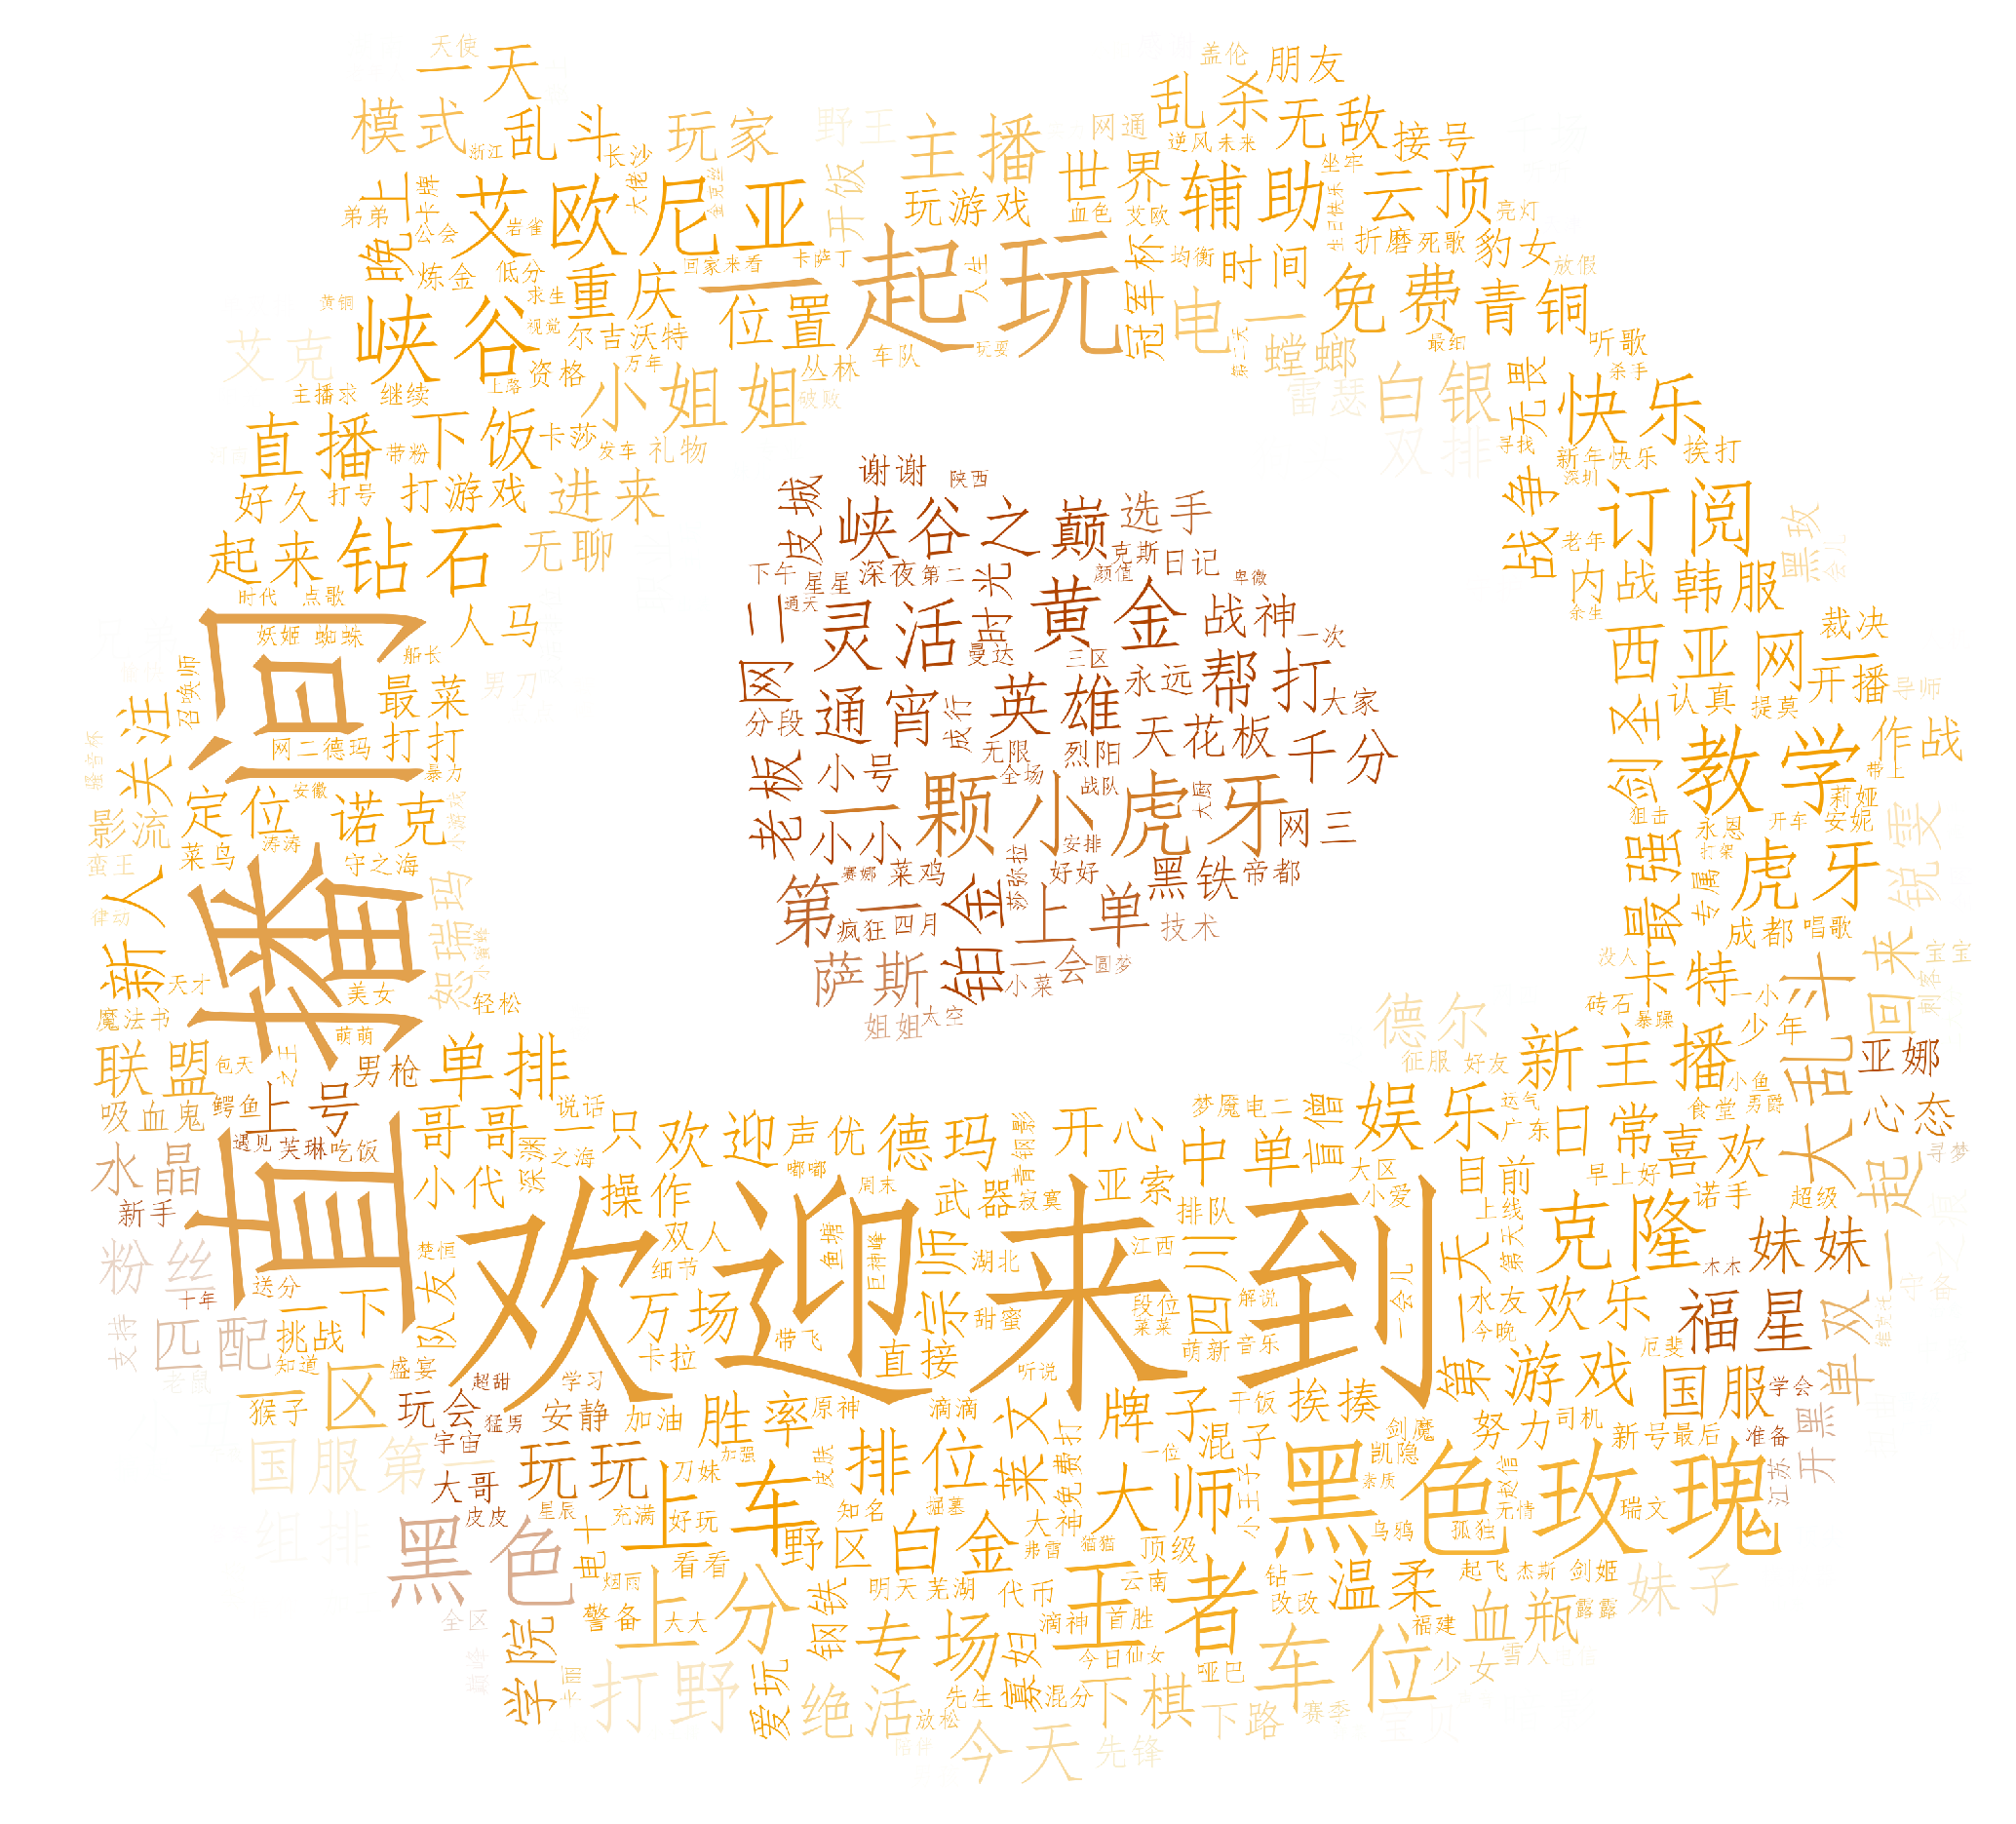

In [70]:
word_cloud = WordCloud(scale=4, background_color="white",  # 背景颜色  # scale=4,
                       mask=graph, font_path='simfang.ttf',    # 指定词云的形状 ; 设定中文字体  'simsun' 是宋体
                      max_words=500, color_func=pic_color,   # max_words 最多能显示的词数小？    max_words=2000,  
                      max_font_size=100,                     # 最大字体的大小
                      collocations=False)                    # 不输出重复值
word_cloud.generate(text_cut)
plt.subplots(figsize=(10,8), dpi=150)
plt.imshow(word_cloud)
plt.axis("off")
plt.savefig('images\直播标题词云图.png', format='png', bbox_inches='tight',  # 保存图片
                dpi=300, transparent=True)

#### 公告主题

In [9]:
# 从个人信息.csv导入公告到pht表
个人信息表 = pd.read_csv('data\个人信息.csv')
ann_dict = 个人信息表.set_index('用户id')['公告'].to_dict()

pht['公告'] = pht.用户id.map(ann_dict)
pht.公告.fillna('', inplace=True)     # 填充公告缺失值为空''

D:\software\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


##### 第一步，生成嵌套列表

In [16]:
公告词袋 = pht.公告.apply(lambda x: re.sub(r, '', x)).map(jieba.cut).map(list).to_list()
pht['公告词袋'] = 公告词袋

公告词袋[:2]       # 查看嵌套列表

[['直播', '时间', '晚上', '点播', '到', '凌晨', '点'], ['粉丝', '直播', '时间', '晚上', '点点']]

##### 第二步：构建字典——dictionary

In [81]:
dictionary = corpora.Dictionary(公告词袋)     # 生成词频字典 {词：频率}

print(dictionary)

Dictionary(10772 unique tokens: ['凌晨', '到', '时间', '晚上', '点']...)


In [82]:
# 手动去除一些没有实际意义词(单个字的词)，弥补停用词不全面的缺点
bad_ids = []
for key,value in dictionary.token2id.items():
    if len(key)==1:    # 如果词为单个字，那么将其id存放到bad_ids列表中
        bad_ids.append(value)
dictionary.filter_tokens(bad_ids=bad_ids)   # 去除bad_ids列表中的词id
dictionary.compactify()    # 去除了单个字的词之后，重新对单词id进行排序。

##### 第三步：构建语料库——corpus

In [83]:
corpus = [dictionary.doc2bow(text) for text in 公告词袋]  # 生成语料库

corpus[:2]              # 查看语料库

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)],
 [(1, 1), (2, 1), (4, 1), (5, 1), (6, 1)]]

##### 第四步：训练LDA模型

In [22]:
# LDA模型的训练
num_topics = 3        # 设置主题个数
lda = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
        iterations=500, random_state=123)

##### 第五步：选择合适的主题个数

In [23]:
# 保存2-15个主题数的lda模型，迭代次数为500
for num_topic in range(2, 16):
    lda = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic,
        iterations=500)
    lda.save('LDA模型数据\lda_model_公告\lda_topic%s.model'%num_topic)

###### 5.1 困惑度确定主题数范围

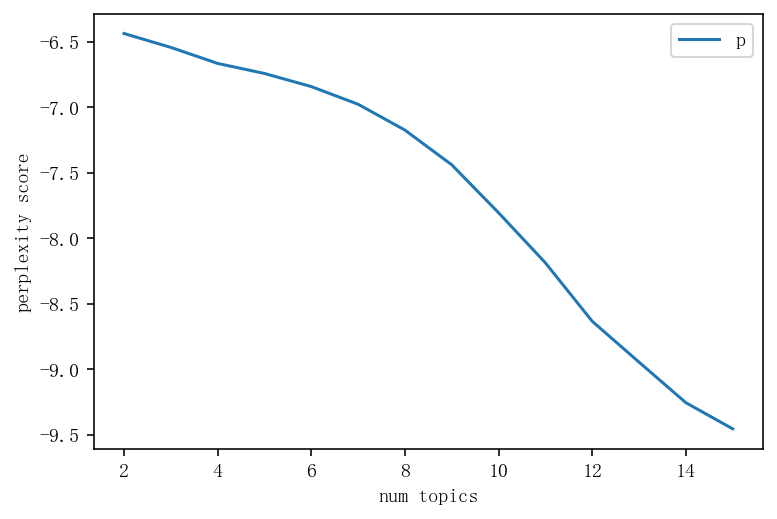

In [26]:
perlexity_list = perplexity_visible_model(topic_range=range(2, 16), model_path='LDA模型数据\lda_model_公告')

由上图发现，当主题个数超过8时，模型的困惑度就会急剧下降。故初步将主题数定在3-5之间。

###### 5.2 绘制主题数和一致性的变化

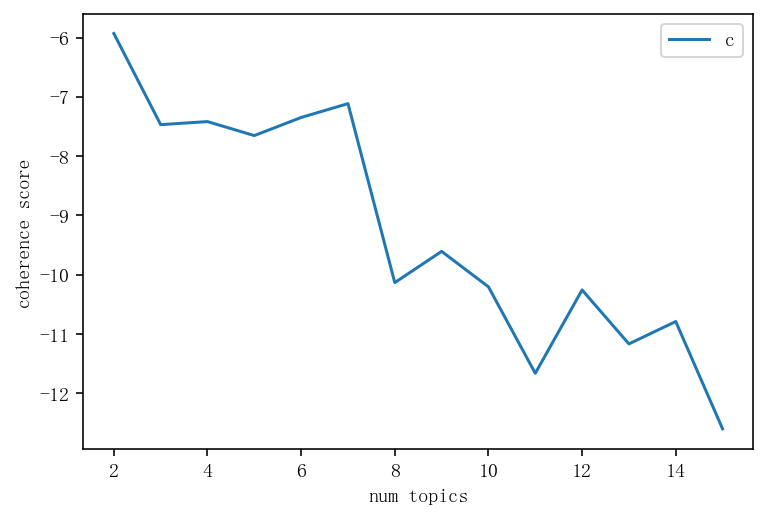

In [27]:
coherence_list = coherence_visible_model(model_path='LDA模型数据\lda_model_公告', topic_range=range(2, 16))

当主题数为2、4、7时，模型评分最高。综合后续的定性分析（取每个主题最高概率的公告进行定性分析），认为主题为4时，主题区分度最大，故将主题数定为4。

###### 5.3 可视化模型

In [84]:
import pyLDAvis.gensim

num_topic = 4
lda = models.ldamodel.LdaModel.load('LDA模型数据\lda_model_公告\lda_topic%s.model'%num_topic)
vis_data = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.show(vis_data, open_browser=False)

<>:4: DeprecationWarning: invalid escape sequence \l
<>:4: DeprecationWarning: invalid escape sequence \l
<>:4: DeprecationWarning: invalid escape sequence \l
<ipython-input-84-4d2be5edd8a2>:4: DeprecationWarning: invalid escape sequence \l
  lda = models.ldamodel.LdaModel.load('LDA模型数据\lda_model_公告\lda_topic%s.model'%num_topic)
D:\software\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))



Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [08/Oct/2021 18:20:59] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [08/Oct/2021 18:21:00] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [08/Oct/2021 18:21:00] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [08/Oct/2021 18:21:00] code 404, message Not Found
127.0.0.1 - - [08/Oct/2021 18:21:00] "GET /favicon.ico HTTP/1.1" 404 -
----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 57138)
Traceback (most recent call last):
  File "D:\software\Anaconda3\lib\socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "D:\software\Anaconda3\lib\socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "D:\software\Anaconda3\lib\socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "D:\software\Anaconda3\lib\socketserver.py", line 720, in __init__
    self.handle()
  File "D:\softwar


stopping Server...


##### **第六步：查看各主题的主题词**

In [45]:
num_topic = 4
lda = models.LdaModel.load('LDA模型数据\lda_model_公告\lda_topic%s.model'%num_topic)  # 读取提前存储的模型

# lda.print_topics(num_words)：获取每个主题前`num_words`个重要的单词
topic_list = lda.print_topics(num_words=12)

# 整理成dataframe结构，方便查看
pd.DataFrame([re.findall('"(.*?)"', t[1]) for t in topic_list])

# 主题1：大神直播
# 主题2：欢迎来到××的直播间，没有什么信息含量
# 主题3：新人求订阅
# 主题4：直播时段、打赏机制

<>:2: DeprecationWarning: invalid escape sequence \l
<>:2: DeprecationWarning: invalid escape sequence \l
<>:2: DeprecationWarning: invalid escape sequence \l
<ipython-input-45-6d77eb9e66b0>:2: DeprecationWarning: invalid escape sequence \l
  lda = models.LdaModel.load('LDA模型数据\lda_model_公告\lda_topic%s.model'%num_topic)  # 读取提前存储的模型


,0,1,2,3,4,5,6,7,8,9,10,11
0,游戏,开播,主播,峡谷,王者,直播,英雄,开心,娱乐,晚上,联盟,辅助
1,直播间,欢迎来到,虎牙,操作,无聊,少年,一只,小小,喜欢,铭轩,开播,永远
2,主播,订阅,大家,一颗小虎牙,欢迎,直播间,直播,粉丝,喜欢,欢迎来到,定时,关注
3,直播,时间,晚上,粉丝,下午,主播,开播,订阅,牌子,关注,联盟,游戏


In [ ]:
1. 能力展示（峡谷、王者）
2. 信息少
3. 欢迎主播
4. 直播时间（晚上、下午、定时）

##### **第七步：打印出dataframe中各个直播间标题所属主题的概率。**  

In [46]:
num_topic = 4
lda = models.LdaModel.load('LDA模型数据\lda_model_公告\lda_topic%s.model'%num_topic)
lda_result = pht.公告词袋.apply(lambda x: lda.get_document_topics(dictionary.doc2bow(x)))
lda_result[:3]     # 主题0——概率0.8， 主题1——概率0.08，主题2——概率0.08

<>:2: DeprecationWarning: invalid escape sequence \l
<>:2: DeprecationWarning: invalid escape sequence \l
<>:2: DeprecationWarning: invalid escape sequence \l
<ipython-input-46-bc90d2ce4e6c>:2: DeprecationWarning: invalid escape sequence \l
  lda = models.LdaModel.load('LDA模型数据\lda_model_公告\lda_topic%s.model'%num_topic)


0    [(0, 0.041883536), (1, 0.041705407), (2, 0.041...
1    [(0, 0.041947994), (1, 0.041700885), (2, 0.043...
2    [(0, 0.9402622), (1, 0.019621532), (2, 0.01998...
Name: 公告词袋, dtype: object

In [55]:
# 在测试期间需要重复运行此代码，为防止重复出现多列重名的情况，需要提前删除列
for i in range(1, 10):
    try:
        pht.drop(columns='公告Topic%s'%i, inplace=True)
    except:
        pass
# 将Series转化为[{}, {}, ...{}]格式，以便转为dataframe格式——Topics，然后与pht表合并
lda_result_data = lda_result.map(dict).to_list()

Topics = pd.DataFrame(lda_result_data)
Topics.columns = ['公告Topic%s'%i for i in range(1, num_topic+1)]
pht = pd.concat((pht, Topics), axis=1, join='inner')
pht.head(2)

,用户id,直播标题,公告,公告词袋,公告主题,公告主题概率,公告Topic1,公告Topic2,公告Topic3,公告Topic4
0,1820796294,打把大号维护局！,直播时间晚上9点播到凌晨4点,"[直播, 时间, 晚上, 点播, 到, 凌晨, 点]",1,0.473651,0.041884,0.041705,0.041853,0.874559
1,2183525275,韩服乱杀职业选手,粉丝群：864936115 直播时间 晚上8点-2点,"[粉丝, 直播, 时间, 晚上, 点点]",1,0.856851,0.041948,0.041701,0.043451,0.872900


In [56]:
# pht['Topic']   公告间标题的主题
pht['公告主题'] = pht[['公告Topic%s'%i for i in range(1, num_topic+1)]].apply(lambda x: x.argmax()[-1], axis=1)
pht['公告主题概率'] = pht[['公告Topic%s'%i for i in range(1, num_topic+1)]].max(axis=1)
pht.公告主题.value_counts()

D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  


2    5140
4    2729
3    1651
1    1441
Name: 公告主题, dtype: int64

In [58]:
a = pht.sort_values('公告主题概率', ascending=False)
for i in range(1, num_topic+1):
    print('——————Topic%s——————'%i)
    display(a[a.公告主题==str(i)].公告.head(20))    # head(n) 显示每个主题的前n条信息

# 主题1：大神直播
# 主题2：欢迎来到××的直播间，没有什么信息含量
# 主题3：新人求订阅
# 主题4：直播时段、打赏机制

——————Topic1——————


2787    虎牙最强龙女：速度战，一人战法，神鬼疾风，逆转战局！——！一击不中远遁千里！侵略如火疾驰如风...
7062    天使克拉夫，拉夫砍龙王，龙王喷天使\n9森来狗分\n三国清场快\n忍刺秒法师\n小炮吃烂分\...
292     全网最强俄洛伊教学\nS7三个区的王者保持者\nS9峡谷宗师保持者，峡谷最高分\n峡谷之巅英...
9690    蛤蟆本是痴情种，敢为红颜惹恶人，此去瑶池求灵药，愿用蛙命换鹅生，奈何天鹅伤好时，终究还是念旧...
2565    挥不掉英雄泪，忘不掉家国恨；\n喝不完杯中酒，唱不完别离歌；\n放不下手中剑，守一放国泰民安...
1111    人生无处不相逢，愿世间美好与你换环环相扣！\n主播主玩LOL与绝地，游戏水平一般，理解不错，...
6213    过年期间每天开播~\n原峡谷之颠大师守门员现投奔云顶，\n啥阵容都会，教学能力极强，\n还免...
6339    千场菜鸭烬！\n都说人生如场戏，指尖把玩令珍惜。\n枪落花开谁哭泣，万里狙击无人敌。  （死...
1737    s10国服峡谷前50   主玩豹女   死歌 艾克  蜘蛛 人马   莉莉娅  岩雀  全能...
633       吃鸡王，自带战术目镜，看到人的第一感觉就是我的外卖在跑，红点当8倍，绝地岛战略教学请收看二郎！
2       湖北40大叔.主玩赵信!颜值不高 身材不好 技术不够 只有一杆长枪战峡谷,一腔热血闯虎牙!薇...
1458                  英雄联盟，火箭联盟，守望先锋，小霸王游戏机。乐高和少儿编程方面也会直播
728     一个人总要走陌生的路，看陌生的风景，听陌生的歌。然后在某个不经意的瞬间你会发现，原本费尽心机...
6360    抽象游戏 娱乐主播 比尔吉沃特第一拉跨，豹子头零充。扣扣群：912929372。不定时不定期...
4864                  S11 血色流克烈开创者 暮刃 血手 铁板靴 贪欲九头蛇 复活甲 黑切
4636    购买正宗白毫银针（出厂价）或主播打号 V  a617189350\n想找 王者陪玩+代练也可...
144     峡谷s10第一 各种辅助打中凯瑞 第一琴女 牛头 芬妮。群：120066736主播v：lin...
2847       主播Q

——————Topic2——————


4006                        永远年轻 永远骂人难听 永远作精 永远谁的话都不听
2390     接上分陪玩vx：CXMCLM\n厄斐琉斯瞬3q 一秒6a 莹炎r3aq 收集者月男开发人
10177                            欢迎来到 放肆的青春诠释了悲伤 的直播间
10331                            欢迎来到 秋水-招陪玩带厅团队 的直播间
7853         一切都是命，遇到了是命，遇不到也是命。遇到了擦肩而过是命，遇到了天各一方也是命。
2164                              欢迎来到 星星丶野区霸主浩哥 的直播间
3249                             欢迎来到 鱼塘-一纯-威伦帅哥 的直播间
8264                              欢迎来到 阿斯顿法国红酒快乐 的直播间
10920               欢迎来到猛男弟弟的直播间  你想玩什么发公屏我会玩的都可以陪你们玩
10757                              欢迎来到 电商设计在线卖货 的直播间
10656                              欢迎来到 奥莉安娜与赞美诗 的直播间
10946                              欢迎来到 文家铁骑-潘小帅 的直播间
10552                             欢迎来到 无花无酒【王一川】 的直播间
10911                              欢迎来到 热恋中从未听讲过 的直播间
6800                                欢迎来到 寻梦-疯狂小龙 的直播间
8081                                 欢迎来到 狴犴永远滴神 的直播间
4169                             欢迎来到 星诺-无情【然弟弟】 的直播间
8888                           欢迎来到 Dae-春娇-难逃北晚安 的直播间
4863                        

——————Topic3——————


8033     新人主播正在努力，希望得到大家的支持，播好每一场直播，为您带来视觉上的满足与开心😁\n   ...
14       久伴昵称：软眠眠X的一批\n每月5号守护日，开通守护可获得神秘定制礼物\n带久伴昵称开通骑士...
10938    欢迎大家来到我的直播间 ，我就是娱乐一下 技术不好 想必和大多数玩家一样 有喜欢看下饭操作的...
666      狂鸟丶折磨王，新人主播，希望各位进来看看点点订阅就是对我最大的支持。卡爷字贵宾14级粉丝徽章...
1431     感谢每位小伙伴前来观看我直播，LOL水平的确菜了点也望观众们多多包涵，也望看我直播的每一位朋...
311      号已经到大师~现在每天不定时直播，开播第一个来的兄弟帮锤号一到两把 为了心中的电竞梦 甚至可...
5895     欢迎来到逗逼团酱的小窝\n喜欢主播点下订阅\n刷刷免费礼物\n主播粉丝群：295296821...
3279     虽然菜，但是为了涂一乐。可以的话希望大家关注订阅走一波，谢谢各位，点个关注订阅，吃不了亏，上...
2266     欢迎大家 本人因为工作不定时直播大家体谅一下哈\n大佬群：983588896 欢迎各位大佬加...
401         主播主玩女刀中单四千多场70 多胜率喜欢主播的可以点点关注喜欢女刀的同学也可以跟主播讲包教学
170         欢迎大家来到我的直播间，主播新人，性格脾气好，不做作，欢迎认识大家，直播群492740023
8333     世界未亡，死不投降，需要打号的小伙伴也欢迎加主播微信进入微信群私聊群主  199055932...
8844     每天9.30～12点直播，进来的都是大哥。给点点订阅!在巨神峰的小伙伴可以加下开黑群，有空大...
27       每晚十点到早上累成狗！主播Q/V同号:312399952  每月18日超级粉丝日四倍亲密和上...
2706             不要刷任何礼物！纯粹播着玩的！谢谢！喜欢的点个订阅就行！欢迎大哥大姐的到来！谢谢！
4189         本人新主播一枚，喜欢的可以点一下订阅谢谢大家！！！喜欢喷主播的也可以点个订阅以便随时来喷♥
321                        主播四川成都人，主玩上单，狗熊，锐雯！喜欢点个订阅，谢谢大

——————Topic4——————


6743     八级牌子进群，十级牌子报销改马甲，十四级牌子神秘礼物，20级牌子奖励自制板鸭一只，卡永久车位...
22       粉丝群592472812直播时间下3点到晚上1点，主播大号王者1200分，峡谷剑魔单排王者8...
828      粉丝福利:10级牌帮打号一天+钻粉一个月，13级牌帮打号一天+房管，15级牌帮打两天+永久钻...
10585    10级牌子进微信群，报销更名卡；12级牌子送星野兔家专属手绘版虎牙头像；16级牌子送皮肤/零...
3178     喜欢主播的可以点一下订阅，主播会教学打野\n白金或者以下一单打一盘，下4单送1单\n钻石局下...
4271     河北石家庄小姐姐，游戏全能，可峡谷可下棋，直播时间：早上和晚上段 喜欢的哥哥可以改个马甲格式...
8859     不懂私信我或者b站搜KK桑视频评论区问\r主播打AD：莎弥拉真爱粉\r喜欢莎弥拉的可以来一起...
5040     直播时间：晚上12点-早上7点！定播【云顶之弈】偶尔玩其他主机游戏！加wx粉丝群扣666！目...
1781     阿卡丽粉丝群1134843580 \n粉丝群内有对线技巧、出门装推荐、高分段阿卡丽主播、对线...
8009     十级牌子可以进vx粉丝群哦\r家人马甲格式：XXXX【守护蛮蛮】\r直播时间：16:00-2...
7648     直播内容:英雄联盟、绝地求生、堡垒之夜\n欢迎加入虎牙狂魔粉丝群:729744619\n各位...
2056     随缘直播 直播时间大都是晚上七八点 谢谢大家爱看我直播！每次一直播就来看我 我好开心！ 请大...
6879     新主播.求家人.求守护 .\n单号直播11点到晚上9点稳定在线直播\n马甲格式：名字后面+【...
414      早上7点-14.00休息三小时下午17-00-22.00直播都是白金钻石局全程教学，学不会直...
3467     直播时间可加企鹅群866151025掌握！！\n想尝试解说可私聊或企鹅私聊\n欢迎关注微博@...
561              【万场小丑】直播时间白天-晚上，十级牌子上一个小段，十二级牌子送房管送包天送粉钻。
493        直播时间：每天全天时段播8+小时、（每日免费虎粮升级粉丝徽章兑换福利）18级=全包杭州三日

##### 第八步：储存为字典.txt

In [67]:
# 储存{用户id：公告}字典
with open('data\用户id_公告字典.txt', 'w') as f:    
    ann_id = str(pht.set_index('用户id')['公告主题'].to_dict())
    f.write(ann_id)

##### 第九步：绘制词云图

In [59]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from PIL import Image                            # 读取图片
# text_cut = 'recommend go use money someth 3 button stop work month use...' # text_cut的格式：把词袋拼接成str

background = Image.open("data/虎牙图标.png")
graph = np.array(background)
pic_color=ImageColorGenerator(graph)   #根据图片生成颜色函数

text_cut = ' '.join(pht.公告词袋.apply(lambda x: ' '.join(x)).to_list())

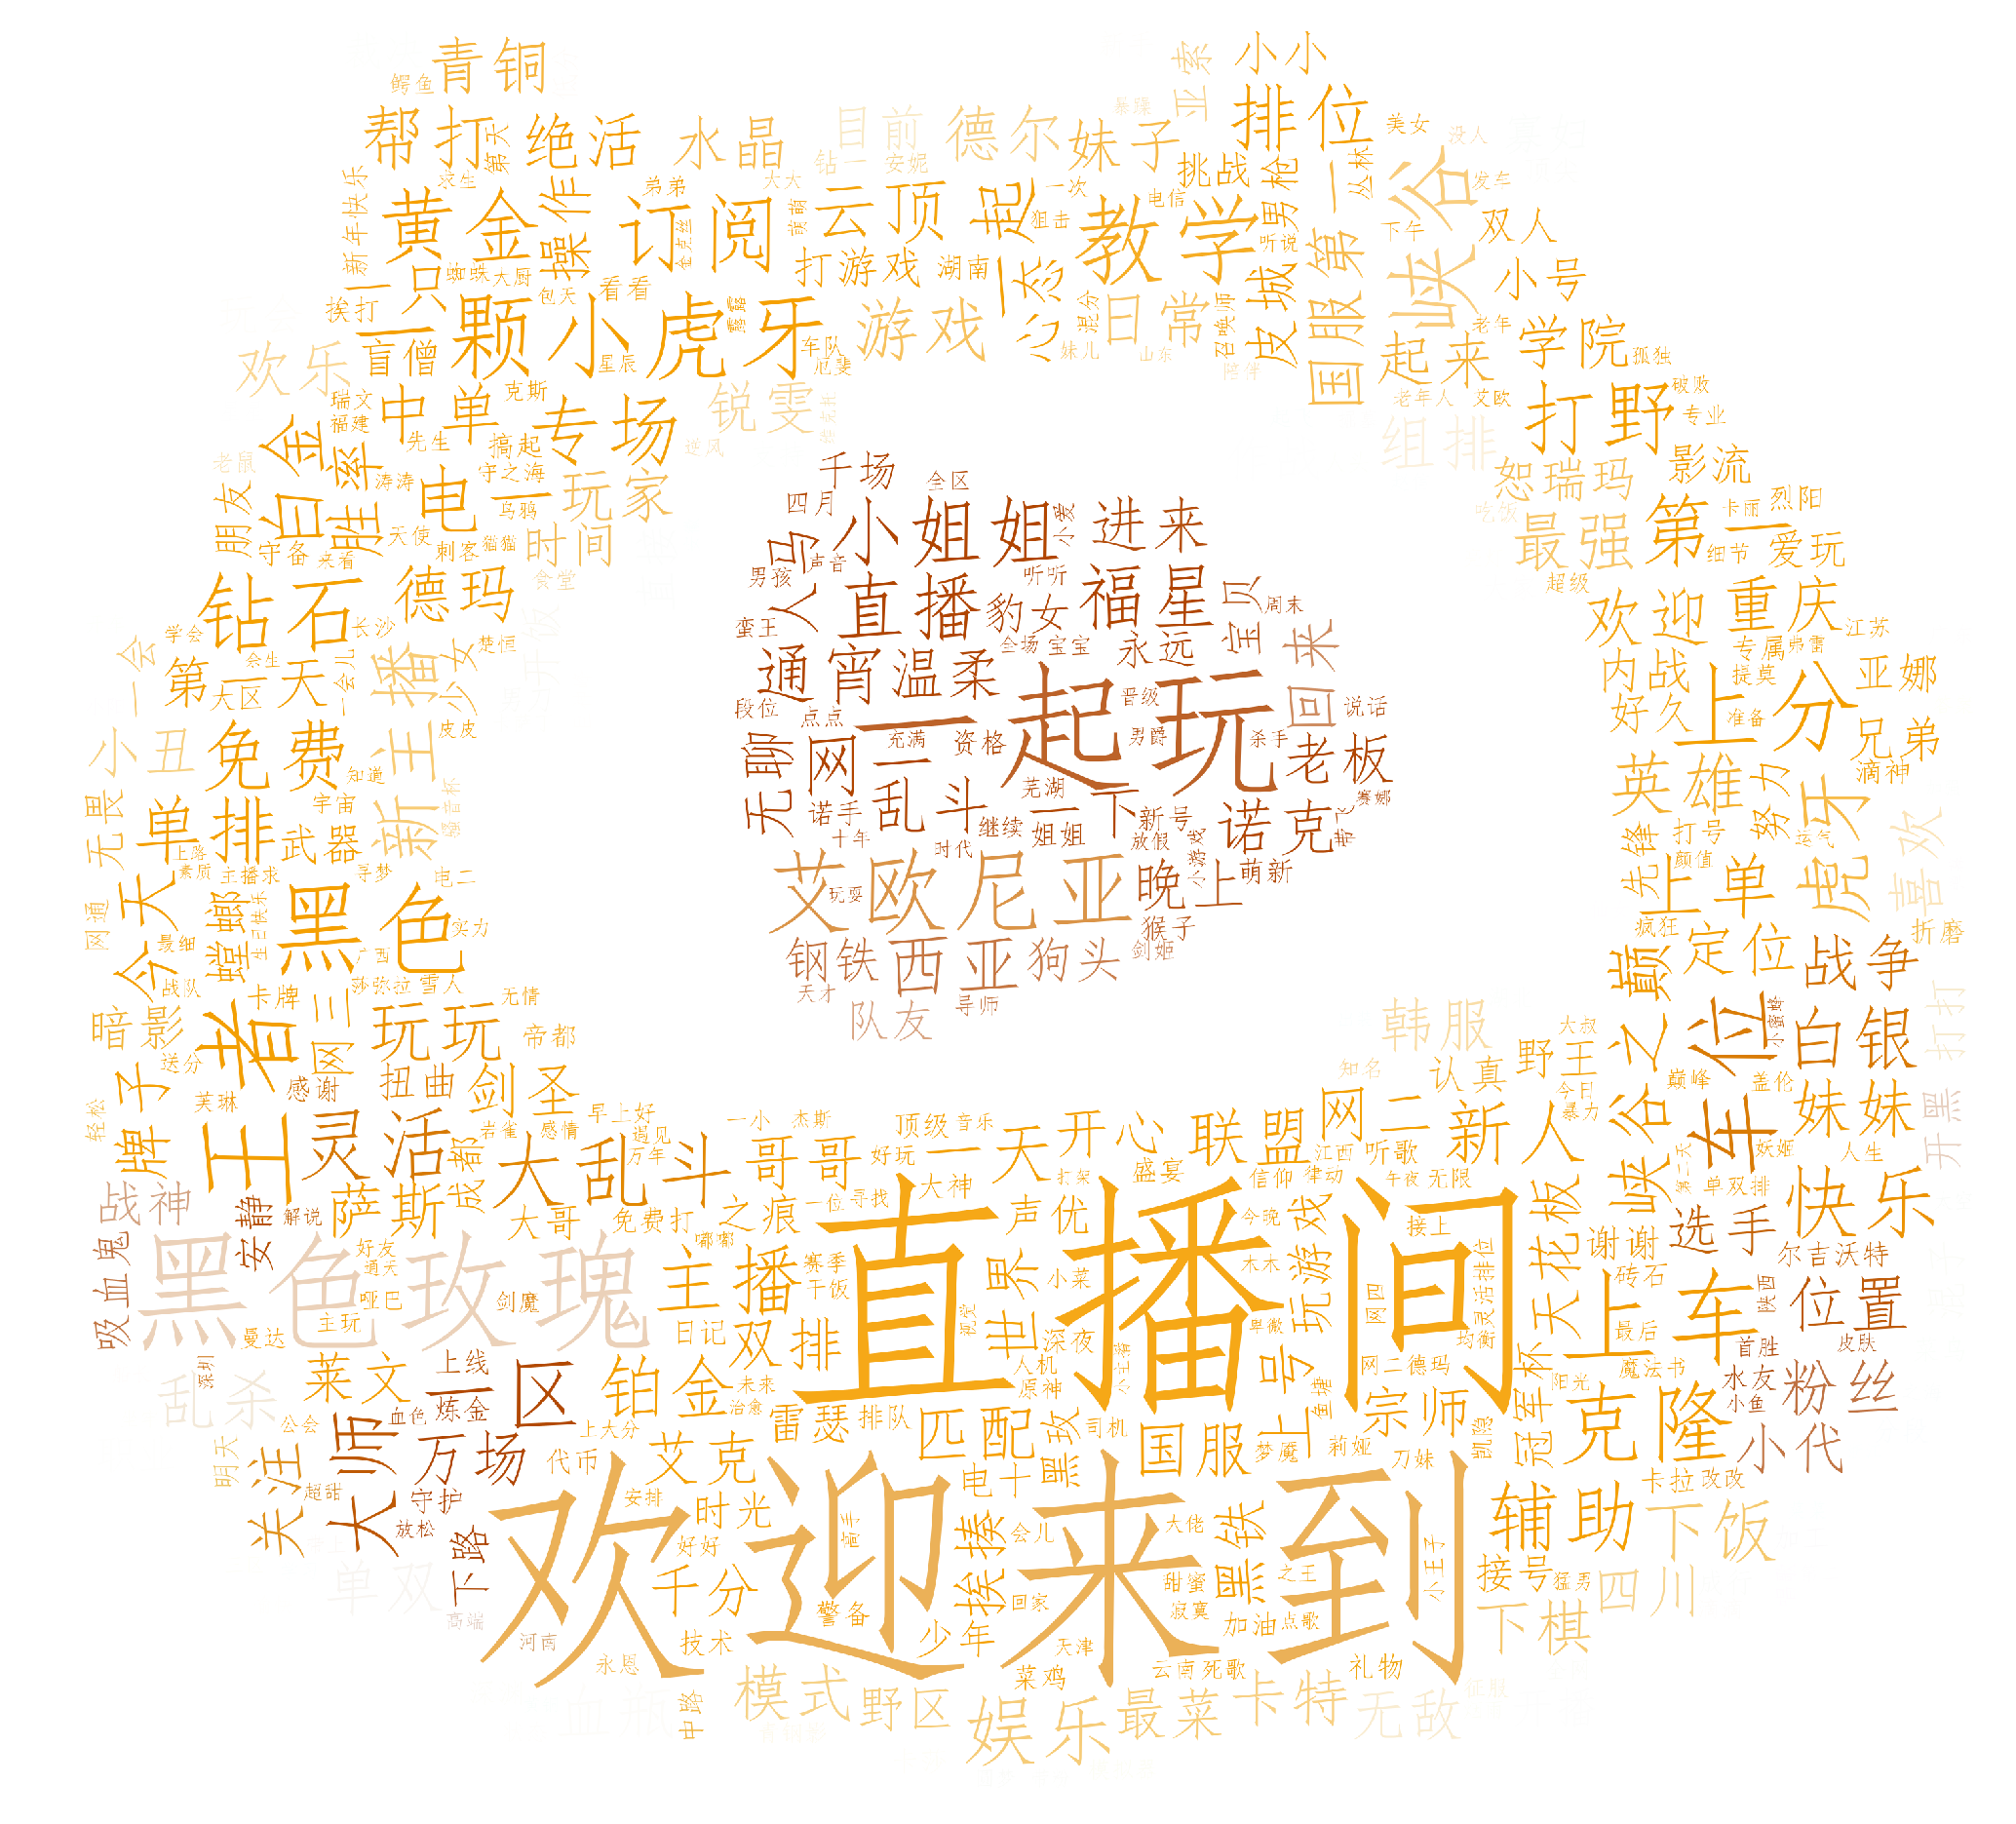

In [68]:
word_cloud = WordCloud(scale=4, background_color="white",  # 背景颜色  # scale=4,
                       mask=graph, font_path='simfang.ttf',    # 指定词云的形状 ; 设定中文字体  'simsun' 是宋体
                      max_words=500, color_func=pic_color,   # max_words 最多能显示的词数小？    max_words=2000,  
                      max_font_size=100,                     # 最大字体的大小
                      collocations=False)                    # 不输出重复值
word_cloud.generate(text_cut)
plt.subplots(figsize=(10,8), dpi=150)
plt.imshow(word_cloud)
plt.axis("off")
plt.savefig('images\公告词云图.png', format='png', bbox_inches='tight',  # 保存图片
                dpi=300, transparent=True)